In [1]:
from IPython.display import display
import misc
import matplotlib as mpl
import os
import re
import seaborn as sns
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
from collections import defaultdict
import matplotlib.pyplot as plt
import yaml
import sys
import scanpy as sc
from anndata import AnnData

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from misc import rename_cytokines, rename_CMs, rename_bloods, rename_factors, rename_factor, rename_Y, make_annot, convert_partial_year, rename_pathways
import bcg_utils as utils

%load_ext autoreload
%autoreload 1
%aimport misc
%aimport bcg_utils
%aimport bcg_colors

from bcg_colors import *

In [2]:
_ = utils.setup_plotting(style='ticks', context='notebook', font_scale=1, rc=RC_PAPER)

FIG_SIZE = (1.25, 1.25)
HEATMAP_SIZE = (0.3, 0.3)
CIRCLE_SIZE = 20
CIRCLE_LINE_WIDTH = 0.4
ALPHA = 0.8
LGD_MARKER_SCALE = 1.2

FDR = [0.05]
ATAC_FDR = [0.1]
VOLCANO_MAX_ANNOT = 20
CELL_SIZE = 0.25
LM_VMAX = 5
LM_VMIN = -1 * LM_VMAX
ENR_VMAX = 7
ENR_VMIN = -1 * ENR_VMAX
LOLA_VMAX = 150
LOLA_VMIN = -1 * LOLA_VMAX
TRANSPOSE_ENR_TABLE = True
ENR_FIG_WIDTH, ENR_CELL_HEIGHT = (3, 0.127) if TRANSPOSE_ENR_TABLE else (10, 0.1)
AGE_EFFECT_PER_N_YEARS = 10
PVAL_ASTERISKS = [0.05, 0.01, 0.001]

SAVE_FIG = True
fig_dir = utils.make_dir('results', 'figures', 'Figure2')
CELLTYPE = 'PBMC'
TOP_N = 1000
RANK_METRIC = 'p.value'

# Suppl. Tables

In [3]:
SAVE_TABLES = True
SUPPL_LIMIT = 5000
if SAVE_TABLES:
    suppl_tables = misc.get_container_with_tables([ATAC_V1, ENRICH_V1, ATAC_V1_FULL_HOST_FACTORS, ENRICH_V1_PROMOTERS, ENRICH_V1_LOLA])

## Across-donor variability

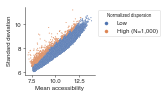

In [4]:
HIGH_VAR_N = 1000
adata = AnnData(X=pd.read_csv(misc.COMBAT_COUNT_DATA_FN.format(celltype=CELLTYPE), index_col=0).T)
adata.X -= (adata.X.min() - 0.1)
assert np.abs(adata.X.min() - 0.1) < 1e-6
hvr_df = sc.pp.highly_variable_genes(adata, n_top_genes=HIGH_VAR_N, flavor='cell_ranger', inplace=False)
hvr_df.index = adata.var_names
dispersions_norm = hvr_df['dispersions_norm'].copy()
dispersions_norm.index.name = REGION_COL

thr_high_var = dispersions_norm.sort_values(ascending=False).iloc[HIGH_VAR_N]
hue = np.asarray(['Low'] * len(dispersions_norm), dtype=object)
hue[dispersions_norm >= thr_high_var] = f'High (N={HIGH_VAR_N:,})'
x = np.log2(np.power(2, adata.X).mean(axis=0))
y = np.log2(np.power(2, adata.X).std(axis=0))
sort = np.argsort(dispersions_norm)
x=x[sort]
y=y[sort]
hue=hue[sort]
idx = np.arange(len(hue))
idx = np.concatenate([np.random.RandomState(misc.RANDOM_STATE).choice(idx[hue == 'Low'], size=(hue == 'Low').sum(), replace=False),
                      idx[hue != 'Low']])

fig, ax = plt.subplots(1, 1, figsize=FIG_SIZE)
ax = sns.scatterplot(x=x[idx], y=y[idx], hue=hue[idx], palette='deep', linewidth=0.05, s=1, rasterized=True)
ax.set_xlabel('Mean accessibility')
ax.set_ylabel('Standard deviation')
ax.legend(title='Normalized dispersion', bbox_to_anchor=(1, 1))
sns.despine()
utils.savefig(os.path.join(fig_dir, f'variable_regions.highVar{HIGH_VAR_N}.svg'), dpi=DPI)
# del adata, x, y, hue

Using this peak annotation: ../data/DE/peaks_filtered_PBMC.csv.gz
Region
CONS00000009234    99.007859
CONS00000112483    98.846531
CONS00000210569    98.094511
Name: FVE, dtype: float64
median (1000): 43.0723106888656
mean (1000): 46.524507037233846


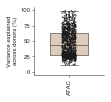

INFO: The 5000 selected regions contain the top 1000 regions with GENE_AND_DISTAL_10kb mapping.


,FVE,Dispersion (normalized),Promoter mapping,Distal mapping
Region,,,,
chr1_109687442_109688553,0.990079,127.458611,GSTM1,GSTM1
chr8_8227202_8229403,0.988465,218.141237,NaN,NaN
chr20_1587681_1589171,0.980945,124.006222,SIRPB1,SIRPB1
chr7_102671260_102672129,0.972692,92.092362,POLR2J2,POLR2J2
chr7_74850820_74851714,0.970332,93.371465,GTF2IRD2,GTF2IRD2


In [5]:
LMM = True
peaks_df = misc.get_peak_annot()
DREAM_MODEL = 'varPartTop.batch_TSS_enr_blood_corrected.donor' if LMM else None
var_df = pd.read_csv(misc.de_fn(CELLTYPE, DREAM_MODEL, data='variance'), index_col=0)
for g in ['SAMPLE.VISIT', 'PBMC_PERC']:
    cols = var_df.columns[var_df.columns.str.startswith(g)]
    if len(cols) != 0:
        g_sum = var_df[cols].sum(axis=1)
        var_df.drop(cols, axis=1, inplace=True)
        var_df[g] = g_sum
var_df = var_df.stack().rename('FVE')
var_df.index.names = [REGION_COL, 'contrast']
var_df = pd.DataFrame(var_df).reset_index().set_index(REGION_COL)
var_df['contrast'] = var_df['contrast'].apply(lambda x: 'Across-donor' if x == 'SAMPLE.DONOR' else 'Within-donor' if x == 'Residuals' else x)
var_df['FVE'] *= 100
print(var_df.loc[var_df['contrast'] == 'Across-donor', 'FVE'].sort_values(ascending=False).head(3))

idx = dispersions_norm.sort_values().tail(HIGH_VAR_N).index if HIGH_VAR_N else var_df.index
print('median ({}):'.format(HIGH_VAR_N), var_df.loc[var_df['contrast'] == 'Across-donor', 'FVE'].loc[idx].median())
print('mean ({}):'.format(HIGH_VAR_N), var_df.loc[var_df['contrast'] == 'Across-donor', 'FVE'].loc[idx].mean())

# This will be plotter in a different file together with immune functions variability
across_donors_df = var_df.loc[var_df['contrast'] == 'Across-donor'].loc[idx].copy()
across_donors_df['modality'] = 'ATAC'
across_donors_df.to_csv(os.path.join(fig_dir, 'ATACseq_expl_var_blood_corr.{}.highVar{}.csv'.format('LMM' if LMM else 'fixedEffects', HIGH_VAR_N)))
assert len(across_donors_df['contrast'].unique()) == 1
misc.FVE_boxplot(across_donors_df, x='modality', y_label='Variance explained\n{}s (%)'.format(across_donors_df['contrast'].unique()[0].lower().replace('-', ' ')),
                 palette=[LIGHT_BROWN], figsize=(FIG_SIZE[0], FIG_SIZE[1]), alpha=ALPHA, jitter=0.15, rasterized=RASTER)
if SAVE_FIG:
    utils.savefig(os.path.join(fig_dir, 'ATACseq_expl_var_blood_corr.{}.highVar{}.svg'.format('LMM' if LMM else 'fixedEffects', HIGH_VAR_N)), dpi=DPI)
plt.show()
# del across_donors_df

if SAVE_TABLES:
    suppl_df = misc.suppl_table_atac_seq_donor_var(var_df, dispersions_norm, peaks_df, limit_top_n=SUPPL_LIMIT, enr_top_n=TOP_N, suppl_tables=suppl_tables, table_name=ATAC_V1, fig_n='S2A')
    suppl_df = misc.suppl_table_atac_seq_donor_var(var_df, dispersions_norm, peaks_df, limit_top_n=None, enr_top_n=None, suppl_tables=suppl_tables, table_name=ATAC_V1_FULL_HOST_FACTORS, fig_n='S2')
    
    display(suppl_df.head())

enrichr GO_Biological_Process_2018 GENE_AND_DISTAL_10kb


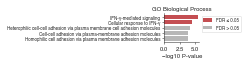

enrichr KEGG_2019_Human GENE_AND_DISTAL_10kb


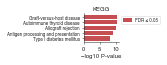

enrichr GO_Biological_Process_2018 TSS_PROXIMAL


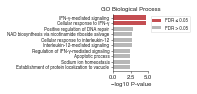

enrichr KEGG_2019_Human TSS_PROXIMAL


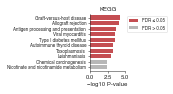

lola HOCOMOCO_v11 None


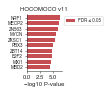

lola Roadmap_Epigenomics_r9 None


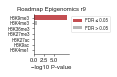

Odds ratio       P-value  \
Library         Gene set                                                        
KEGG_2019_Human Graft-versus-host disease             10.702072  4.292130e-11   
                Autoimmune thyroid disease             8.692441  5.306754e-11   
                Allograft rejection                   11.098532  1.113350e-10   
                Antigen processing and presentation    7.254741  6.974764e-10   
                Type I diabetes mellitus               6.978862  9.763897e-09   

                                                     Adjusted P-value Overlap  
Library         Gene set                                                       
KEGG_2019_Human Graft-versus-host disease                7.137585e-09   16/78  
                Autoimmune thyroid disease               7.137585e-09  18/104  
                Allograft rejection                      9.983041e-09   15/71  
                Antigen processing and presentation      4.690528e-08  18/121  
                Type I diabetes mellitus                 5.252976e-07  16/111

Odds ratio   P-value  \
Library         Gene set                                                    
KEGG_2019_Human Graft-versus-host disease              6.051515  0.000050   
                Allograft rejection                    5.762867  0.000069   
                Antigen processing and presentation    3.750663  0.000211   
                Viral myocarditis                      3.663132  0.000256   
                Type I diabetes mellitus               4.652681  0.000277   

                                                     Adjusted P-value Overlap  
Library         Gene set                                                       
KEGG_2019_Human Graft-versus-host disease                    0.009538   10/30  
                Allograft rejection                          0.009538   10/31  
                Antigen processing and presentation          0.015353   13/55  
                Viral myocarditis                            0.015353   13/56  
                Type I diabetes mellitus                     0.015353   10/36

Odds ratio       P-value  Adjusted P-value  \
Library                Region set                                               
Roadmap_Epigenomics_r9 H3K9me3       2.522971  4.791222e-09      3.353855e-08   
HOCOMOCO_v11           NRF1          1.378237  5.769313e-07      1.547619e-04   
                       MECP2         1.360097  1.067702e-06      1.547619e-04   
                       ZN563         1.720497  1.157819e-06      1.547619e-04   
                       MYCN          1.365057  3.728020e-06      3.737340e-04   

                                     Overlap  
Library                Region set             
Roadmap_Epigenomics_r9 H3K9me3       55/1477  
HOCOMOCO_v11           NRF1        639/36096  
                       MECP2       596/33409  
                       ZN563       927/56467  
                       MYCN        711/41271

In [6]:
suppl_dict = defaultdict(lambda: defaultdict(lambda: {}))
for method, library, region_filter, vmax, vmin, show_only_top_n in [
    ('enrichr', misc.GO_BIO_PROCESS, misc.GENE_AND_DISTAL_10kb, ENR_VMAX, ENR_VMIN, 5),
    ('enrichr', misc.KEGG, misc.GENE_AND_DISTAL_10kb, ENR_VMAX, ENR_VMIN, 5),
    ('enrichr', misc.GO_BIO_PROCESS, misc.TSS_PROXIMAL, ENR_VMAX, ENR_VMIN, 10),
    ('enrichr', misc.KEGG, misc.TSS_PROXIMAL, ENR_VMAX, ENR_VMIN, 10),
    ('lola', HOCOMOCO, None, LOLA_VMAX, LOLA_VMIN, 10),
    ('lola', EPI_ROADMAP, None, LOLA_VMAX, LOLA_VMIN, 10),
]:
    print(method, library, region_filter)
    enr_df = misc.read_enrichr_or_lola(
        CELLTYPE, DREAM_MODEL, library=f'{library}_min15_max500' if method == 'enrichr' else library,
        coef=None, effect_size_filter=None, rank_metric='FVE', top_n=TOP_N, region_filter=region_filter,
        method=method, direction=None)
    enr_df = enr_df.loc[enr_df['Gene_set'] == (f'{library}_min15_max500' if method == 'enrichr' else library)].reset_index()
    assert len(enr_df) != 0
    enr_df['Adjusted P-value'] = misc.adjusted_pvals(enr_df['P-value'], method='fdr_bh')

    if SAVE_TABLES:
        suppl_dict[method][region_filter][library] = enr_df.copy()
        
    enr_df = enr_df.sort_values('P-value')
    if library == misc.GO_BIO_PROCESS:
        enr_df['Term'] = enr_df['Term'].str.replace(' \(GO:[0-9]+\)$', '')
    if show_only_top_n:
        enr_df = enr_df.head(show_only_top_n)
    if (enr_df['Adjusted P-value'] <= np.min(FDR)).sum() < 10:
        enr_df = enr_df.head(10)
    else:
        enr_df = enr_df.loc[enr_df['Adjusted P-value'] < np.min(FDR)]

    colors = np.asarray([LIGHT_GRAY] * enr_df.shape[0])
    colors[enr_df['Adjusted P-value'] < np.min(FDR)] = RED
    fig, ax = plt.subplots(1, 1, figsize=(FIG_SIZE[0] / 2, FIG_SIZE[1] / 12 * enr_df.shape[0]))
    _barh = plt.barh(y=rename_pathways(enr_df['Term'][::-1]), width=-np.log10(enr_df['P-value'].values)[::-1],
                     height=0.75, color=colors[::-1],
                     edgecolor='0.15', lw=0) # mpl.rcParams['lines.linewidth'] / 2
    ax.set_xlabel('{}log10{}P-value'.format(misc.MINUS, misc.NBSPC))
    ax.set_title('{}\nTop {}, {}'.format(library, TOP_N, region_filter))
    ax.tick_params(axis='y', which='both', labelsize=SMALL_FONT)
    ax.set_xticks([0, 2.5, 5] if ax.get_xlim()[1] < 10 else [0, 5, 10])
    ax.set_title('{}'.format(' '.join(library.split('_201')[0].split('_'))), pad=3)
    handles, labels = [], []
    if not all([c == LIGHT_GRAY for c in colors]):
        handles.append(_barh[-1])
        labels.append('FDR {} {}'.format(utils.LESS_EQUAL, np.min(FDR)))
    if LIGHT_GRAY in colors:
        handles.append(_barh[0])
        labels.append('FDR {} {}'.format('>', np.min(FDR)))
    plt.legend(handles, labels, bbox_to_anchor=(1, 1), fontsize=SMALL_FONT)
    sns.despine()
    _ylim_offset = 0.6125
    ax.set_ylim(-_ylim_offset, enr_df.shape[0] - 1 + _ylim_offset)
    if SAVE_FIG:
        utils.savefig(os.path.join(fig_dir, 'inter_donor_variability_enrichment.{}.{}.svg'.format(library, region_filter)))
    plt.show()

for method,  region_filter, table_name, fig_n in [
    ('enrichr', misc.GENE_AND_DISTAL_10kb, ENRICH_V1, 'S2F'),
    ('enrichr', misc.TSS_PROXIMAL, ENRICH_V1_PROMOTERS, None),
    ('lola', None, ENRICH_V1_LOLA, None),
]:
    if SAVE_TABLES:
        suppl_df = misc.suppl_table_enrich_donor_var(suppl_dict[method][region_filter], method=method, limit_FDR=None,
                                                     promoters=region_filter == misc.TSS_PROXIMAL,
                                                     suppl_tables=suppl_tables, table_name=table_name, fig_n=fig_n)
        display(suppl_df.head())

## PCA and cell fractions correlation

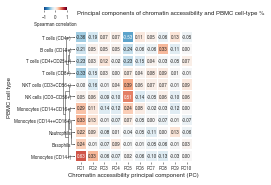

In [3]:
df = misc.get_sample_annot()
atac_df = misc.get_norm_counts(CELLTYPE).T
df = df.loc[atac_df.index, misc.BLOOD]
df = df.loc[~df.isnull().all(axis=1)]
df.columns = misc.rename_bloods(df.columns.str.replace('PBMC_PERC:', 'WB_PER_ML:'), capitalize=True)
assert df.isnull().any(axis=1).sum() < 2
atac_df = atac_df.loc[df.index]
n_dim = 10
pca_df = pd.DataFrame(data=PCA(n_components=n_dim, random_state=misc.RANDOM_STATE).fit_transform(StandardScaler().fit_transform(atac_df)),
                      index=atac_df.index, columns=['PC{}'.format(i + 1) for i in range(n_dim)])

cg, corr_df, pval_df, padj_df = utils.corr_heatmap_with_pvals(
        pca_df, df, corr_method='spearman', optimal_ordering=True, col_cluster=False,
        padj_method='fdr_bh', cluster=True, annot_fmt='.2f', annot='corr',
        dendrogram_ratio=0.1, colors_ratio=0.02825, cell_width=0.32, cell_height=0.22, lw=0.5,
        vmin=-1, vmax=1, cbar_kws=dict(orientation='horizontal'), cbar_pos=(-0.05, 1, 0.1, 0.02),
        xlabel='Chromatin accessibility principal component (PC)', ylabel='PBMC cell type',
        title='Principal components of chromatin accessibility and PBMC cell-type %', annot_size=SMALL_FONT, fig_fn=None, title_offset=1)

cg.ax_heatmap.tick_params(axis='both', which='both', labelsize=SMALL_FONT)
cg.ax_cbar.tick_params(axis='both', which='both', labelsize=SMALL_FONT)
cg.ax_cbar.set_xlabel(cg.ax_cbar.get_xlabel(), fontsize=SMALL_FONT)
cg.ax_cbar.set_ylabel(cg.ax_cbar.get_ylabel(), fontsize=SMALL_FONT)

cg.ax_heatmap.yaxis.set_label_position('left')
cg.ax_heatmap.yaxis.tick_left()
if SAVE_FIG:
    utils.savefig(os.path.join(fig_dir, 'S2_atac_blood_correlation.svg'))
plt.show()

/home/lfolkman/miniconda3/envs/BCG/lib/python3.6/site-packages/seaborn/matrix.py:1190: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  self.fig.tight_layout(**tight_params)


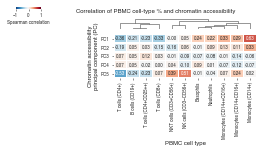

In [7]:
df = misc.get_sample_annot()
atac_df = misc.get_norm_counts(CELLTYPE).T
df = df.loc[atac_df.index, misc.BLOOD]
df = df.loc[~df.isnull().all(axis=1)]
df.columns = misc.rename_bloods(df.columns.str.replace('PBMC_PERC:', 'WB_PER_ML:'), capitalize=True)
assert df.isnull().any(axis=1).sum() < 2
atac_df = atac_df.loc[df.index]
n_dim = 5
pca_df = pd.DataFrame(data=PCA(n_components=n_dim, random_state=misc.RANDOM_STATE).fit_transform(StandardScaler().fit_transform(atac_df)),
                      index=atac_df.index, columns=['PC{}'.format(i + 1) for i in range(n_dim)])

cg, corr_df, pval_df, padj_df = utils.corr_heatmap_with_pvals(
        df, pca_df, corr_method='spearman', optimal_ordering=True, row_cluster=False,
        padj_method='fdr_bh', cluster=True, annot_fmt='.2f', annot='corr',
        dendrogram_ratio=0.2, colors_ratio=0.02825, cell_width=0.32, cell_height=0.22, lw=0.5,
        vmin=-1, vmax=1, cbar_kws=dict(orientation='horizontal'), cbar_pos=(-0.05, 1, 0.1, 0.02),
        ylabel='Chromatin accessibility\nprincipal component (PC)', xlabel='PBMC cell type',
        title='Correlation of PBMC cell-type % and chromatin accessibility', annot_size=SMALL_FONT, fig_fn=None, title_offset=1)

cg.ax_heatmap.tick_params(axis='both', which='both', labelsize=SMALL_FONT)
cg.ax_cbar.tick_params(axis='both', which='both', labelsize=SMALL_FONT)
cg.ax_cbar.set_xlabel(cg.ax_cbar.get_xlabel(), fontsize=SMALL_FONT)
cg.ax_cbar.set_ylabel(cg.ax_cbar.get_ylabel(), fontsize=SMALL_FONT)

cg.ax_heatmap.yaxis.set_label_position('left')
cg.ax_heatmap.yaxis.tick_left()
if SAVE_FIG:
    utils.savefig(os.path.join(fig_dir, 'S2_atac_blood_correlation_small_flipped.svg'))
plt.show()

## Differential analysis

In [8]:
MODEL = 'V1.batch.FACTORS.blood.TSS_enr.visit_time'
with open(f'results/DE/{CELLTYPE}.{MODEL}/de_config_{CELLTYPE}.{MODEL}.yml', 'r') as f:
    config = yaml.load(f, Loader=yaml.loader.FullLoader)
HOST_FACTORS = ['DONOR.AGE', 'DONOR.SEXM', 'DONOR.BMI', 'DONOR.oralContraceptivesIncludingMenTrue', 'SAMPLE.alcoholInLast24hTrue', 'SAMPLE.VISIT_TIME_REAL']
assert set(HOST_FACTORS) == set(config['contrasts'][0])

Using this peak annotation: ../data/DE/peaks_filtered_PBMC.csv.gz


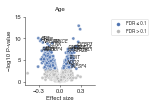

DONOR.AGE: number of regions with <= FDR 0.1: 1192
DONOR.AGE: number of regions with <= FDR 0.1 UP: 496
DONOR.AGE: number of regions with <= FDR 0.1 DOWN: 696 



,gene_name,characterization,distance,feat_type,p.value.DONOR.AGE,Coef.DONOR.AGE,pathways
CONS00000015818,CR2,TSS,33.0,transcript:protein_coding,1.916691e-10,-0.267855,None
CONS00000212346,PYGB,gene_body,12012.0,gene:protein_coding,3.714011e-10,-0.279591,None
CONS00000107512,NRCAM,distal,7070.0,gene:protein_coding,8.777677e-10,-0.242800,None
CONS00000023258,PRKCE,gene_body,29494.0,gene:protein_coding,1.212558e-09,-0.107093,None
CONS00000057111,CLNK,gene_body,13163.0,gene:protein_coding,4.849575e-09,-0.151205,None
CONS00000103269,IGFBP3,TSS_proximal,103.0,transcript:protein_coding,6.224117e-09,0.234042,None
CONS00000135532,RASGEF1A,TSS_proximal,415.0,transcript:protein_coding,2.925920e-08,0.115456,None
CONS00000141172,ACSL5,distal,4387.0,gene:protein_coding,3.037346e-08,0.178912,None
CONS00000105133,GNAI1,gene_body,85027.0,gene:protein_coding,3.354267e-08,-0.219888,None
CONS00000166440,FLT1,gene_body,2429.0,gene:protein_coding,5.496228e-08,-0.219845,None


INFO: The 5000 selected regions contain the top 1000 regions with GENE_AND_DISTAL_10kb mapping.


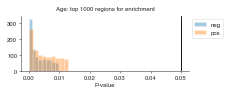

,,Coefficient,T-value,P-value,Adjusted P-value,Promoter mapping,Distal mapping
Region,Host factor,,,,,,
chr15_87597215_87598284,Age,0.270108,7.848120,1.146310e-13,7.343834e-09,NaN,NaN
chr1_240666366_240667166,Age,0.290839,7.545182,7.471457e-13,2.393295e-08,NaN,NaN
chr21_22420940_22422188,Age,-0.307320,-6.822066,8.811220e-11,1.699306e-06,NaN,NaN
chr2_11103605_11104933,Age,0.193502,6.730762,1.060989e-10,1.699306e-06,NaN,NaN
chr1_207470722_207471478,Age,-0.267855,-6.629308,1.916691e-10,2.455856e-06,CR2,CR2


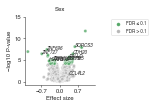

DONOR.SEXM: number of regions with <= FDR 0.1: 53
DONOR.SEXM: number of regions with <= FDR 0.1 UP: 35
DONOR.SEXM: number of regions with <= FDR 0.1 DOWN: 18 



,gene_name,characterization,distance,feat_type,p.value.DONOR.SEXM,Coef.DONOR.SEXM,pathways
CONS00000140712,SORCS3,gene_body,17491.0,gene:protein_coding,8.124702e-09,0.570089,None
CONS00000122760,ZNF696,gene_body_overlap_start,181.0,gene:protein_coding,3.777247e-08,-0.489984,None
CONS00000104111,ZNF727,TSS_proximal,133.0,transcript:protein_coding,3.706180e-07,-0.686052,None
CONS00000202871,CDH20,gene_body,1271.0,gene:protein_coding,3.706485e-07,0.498354,None
CONS00000068221,PALLD,gene_body,1481.0,gene:protein_coding,2.497619e-06,0.339819,None
CONS00000133093,CELF2,gene_body,1101.0,gene:protein_coding,8.529992e-06,0.259004,None
CONS00000191060,ZFPM1,gene_body,17181.0,gene:protein_coding,9.416747e-06,-0.257889,None
CONS00000003028,LAPTM5,gene_body,2930.0,gene:protein_coding,1.098253e-05,0.245980,None
CONS00000111119,ATG9B,gene_body,1788.0,gene:protein_coding,1.231422e-05,-0.177988,None
CONS00000101589,HOXA5,TSS_proximal,165.0,transcript:protein_coding,1.743152e-05,-0.409006,None


INFO: The 5000 selected regions contain the top 1000 regions with GENE_AND_DISTAL_10kb mapping.


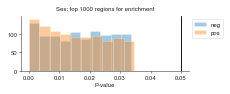

,,Coefficient,T-value,P-value,Adjusted P-value,Promoter mapping,Distal mapping
Region,Host factor,,,,,,
chr20_30283174_30284755,Sex,0.970007,7.471308,1.939884e-12,1.242786e-07,NaN,NaN
chr10_104935369_104936179,Sex,0.570089,5.986915,8.124702e-09,1.936168e-04,NaN,SORCS3
chr20_30288833_30290186,Sex,0.802216,5.981315,9.066578e-09,1.936168e-04,NaN,NaN
chr20_30290211_30291003,Sex,0.829898,5.912064,1.302185e-08,2.085612e-04,NaN,NaN
chr8_143289113_143289875,Sex,-0.489984,-5.674952,3.777247e-08,4.839786e-04,NaN,ZNF696


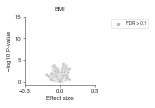

DONOR.BMI: number of regions with <= FDR 0.1: 0
DONOR.BMI: number of regions with <= FDR 0.1 UP: 0
DONOR.BMI: number of regions with <= FDR 0.1 DOWN: 0 



,gene_name,characterization,distance,feat_type,p.value.DONOR.BMI,Coef.DONOR.BMI,pathways


INFO: The 5000 selected regions contain the top 1000 regions with GENE_AND_DISTAL_10kb mapping.


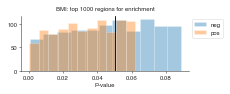

,,Coefficient,T-value,P-value,Adjusted P-value,Promoter mapping,Distal mapping
Region,Host factor,,,,,,
chr12_95998502_95999232,BMI,0.032091,3.955542,0.000098,0.999777,NaN,NaN
chr12_130775793_130777132,BMI,-0.046755,-3.766708,0.000204,0.999777,NaN,NaN
chr6_43312659_43313289,BMI,0.054910,3.739252,0.000230,0.999777,NaN,ZNF318
chr3_58584635_58585926,BMI,0.031829,3.635821,0.000334,0.999777,NaN,FAM107A
chr1_65096916_65097908,BMI,-0.059823,-3.599857,0.000381,0.999777,NaN,NaN


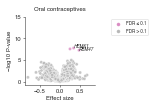

DONOR.oralContraceptivesIncludingMenTrue: number of regions with <= FDR 0.1: 3
DONOR.oralContraceptivesIncludingMenTrue: number of regions with <= FDR 0.1 UP: 3
DONOR.oralContraceptivesIncludingMenTrue: number of regions with <= FDR 0.1 DOWN: 0 



,gene_name,characterization,distance,feat_type,p.value.DONOR.oralContraceptivesIncludingMenTrue,Coef.DONOR.oralContraceptivesIncludingMenTrue,pathways
CONS00000044188,HEMK1,gene_body,4816.0,gene:protein_coding,1.692061e-08,0.340063,None
CONS00000059079,RBM47,gene_body,10349.0,gene:protein_coding,5.588086e-08,0.474305,None


INFO: The 5000 selected regions contain the top 1000 regions with GENE_AND_DISTAL_10kb mapping.


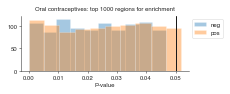

,,Coefficient,T-value,P-value,Adjusted P-value,Promoter mapping,Distal mapping
Region,Host factor,,,,,,
chr3_50573407_50574528,Oral contraceptives,0.340063,5.822498,1.692061e-08,0.000878,NaN,HEMK1
chr3_194306026_194307863,Oral contraceptives,0.250804,5.730966,2.740531e-08,0.000878,NaN,NaN
chr4_40433110_40434120,Oral contraceptives,0.474305,5.609562,5.588086e-08,0.001193,NaN,RBM47
chr21_31354251_31355205,Oral contraceptives,0.283481,4.492886,1.096758e-05,0.175659,NaN,NaN
chr2_236569331_236570102,Oral contraceptives,0.188903,4.379075,1.724666e-05,0.220982,ACKR3,ACKR3


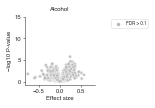

SAMPLE.alcoholInLast24hTrue: number of regions with <= FDR 0.1: 0
SAMPLE.alcoholInLast24hTrue: number of regions with <= FDR 0.1 UP: 0
SAMPLE.alcoholInLast24hTrue: number of regions with <= FDR 0.1 DOWN: 0 



,gene_name,characterization,distance,feat_type,p.value.SAMPLE.alcoholInLast24hTrue,Coef.SAMPLE.alcoholInLast24hTrue,pathways


INFO: The 5000 selected regions contain the top 1000 regions with GENE_AND_DISTAL_10kb mapping.


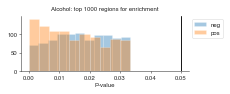

,,Coefficient,T-value,P-value,Adjusted P-value,Promoter mapping,Distal mapping
Region,Host factor,,,,,,
chr10_3851026_3851903,Alcohol,0.241264,4.896380,0.000002,0.109546,NaN,NaN
chr9_88935954_88937170,Alcohol,0.249654,4.329087,0.000021,0.504468,NaN,NaN
chr1_153355333_153356005,Alcohol,0.288260,4.304975,0.000024,0.504468,NaN,S100A9
chr1_110524229_110525042,Alcohol,0.333900,4.091819,0.000057,0.518227,NaN,KCNA2
chr10_14569153_14571187,Alcohol,-0.175062,-4.036068,0.000071,0.518227,NaN,FAM107B


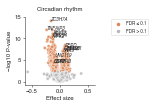

SAMPLE.VISIT_TIME_REAL: number of regions with <= FDR 0.1: 3512
SAMPLE.VISIT_TIME_REAL: number of regions with <= FDR 0.1 UP: 1545
SAMPLE.VISIT_TIME_REAL: number of regions with <= FDR 0.1 DOWN: 1967 



,gene_name,characterization,distance,feat_type,p.value.SAMPLE.VISIT_TIME_REAL,Coef.SAMPLE.VISIT_TIME_REAL,pathways
CONS00000186474,ZC3H7A,gene_body,9635.0,gene:protein_coding,8.613425e-15,-0.159182,None
CONS00000095459,TNFAIP3,gene_body,785.0,gene:protein_coding,1.012168e-12,-0.238284,None
CONS00000186840,XYLT1,gene_body,57232.0,gene:protein_coding,8.780651e-12,-0.125623,None
CONS00000180178,KLF13,gene_body,15287.0,gene:protein_coding,1.252894e-11,-0.119033,None
CONS00000214705,CASS4,gene_body,6732.0,gene:protein_coding,3.164429e-11,-0.128758,None
CONS00000110036,HIPK2,gene_body,33867.0,gene:protein_coding,7.029894e-11,-0.154275,None
CONS00000207824,PEPD,TSS_proximal,172.0,transcript:protein_coding,7.700270e-09,0.090388,None
CONS00000177210,CEP128,TSS_proximal,118.0,transcript:protein_coding,3.655130e-08,0.072535,None
CONS00000044188,HEMK1,gene_body,4816.0,gene:protein_coding,3.976181e-08,0.128610,None
CONS00000032085,DPP4,gene_body,694.0,gene:protein_coding,6.704358e-08,0.129706,None


INFO: The 5000 selected regions contain the top 1000 regions with GENE_AND_DISTAL_10kb mapping.


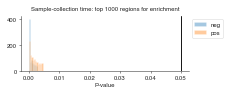

,,Coefficient,T-value,P-value,Adjusted P-value,Promoter mapping,Distal mapping
Region,Host factor,,,,,,
chr16_11782819_11784293,Sample-collection time,-0.159182,-8.234823,8.613425e-15,5.518191e-10,NaN,ZC3H7A
chr6_137881922_137883133,Sample-collection time,-0.238284,-7.505515,1.012168e-12,2.307257e-08,NaN,TNFAIP3
chr6_41732353_41733302,Sample-collection time,-0.136100,-7.486515,1.080429e-12,2.307257e-08,NaN,NaN
chr16_17342790_17344322,Sample-collection time,-0.125623,-7.147666,8.780651e-12,1.406331e-07,NaN,XYLT1
chr15_31365579_31366346,Sample-collection time,-0.119033,-7.089167,1.252894e-11,1.605332e-07,NaN,KLF13


In [9]:
highlights = {
    'DONOR.AGE': ['PRKCE', 'GNAI1', 'FLT1', 'RAPGEF4', 'TIGIT', 'NOD2', 'TNFSF4'],
    'DONOR.SEXM': ['ZNF727', 'HOXA5', 'CCL4L2'],
    'SAMPLE.VISIT_TIME_REAL': ['LITAF', 'CSF2RB', 'UNC119', 'IL4I1', 'TNFAIP3', 'HIPK2'],
}

de_df = misc.read_de(celltype=CELLTYPE, model=MODEL, contrasts=HOST_FACTORS, annot_fn=misc.PEAK_ANNOT_ALL_FN)
de_df.loc[:, misc.coef_col('DONOR.AGE')] *= AGE_EFFECT_PER_N_YEARS

# adjust across all host factors?
# padj_df = misc.adjusted_pvals(de_df[['p.value.{}'.format(c) for c in HOST_FACTORS]].stack()).unstack()
# padj_df.columns = padj_df.columns.str.replace('p.value', 'padj')
# print(padj_df.columns)
# de_df = de_df.drop(padj_df.columns, axis=1)
# de_df = pd.concat([de_df, padj_df], axis=1)

order = [1, 0, 3, 4, 5, 2]
ylim  = (-0.7620399327801415, 15)

for coef, xticks, fig_n in zip(
    HOST_FACTORS,
    [[-0.3, 0, 0.3], [-.7, 0, .7], [-0.3, 0, 0.3], None, None, None],
    ['2E', '2F', 'S2I', 'S2H', 'S2J', '2G']
):

    annot_df = misc.find_top_hits(
        de_df, coef, fdr=np.min(ATAC_FDR), show_n=5, unique_genes=True, highlights=highlights,
        region_filter=misc.GENE_AND_DISTAL_10kb,
#             model=MODEL, celltype=CELLTYPE, top_n=TOP_N,
#             enr_fdr=np.min(FDR), library=['GO_Biological_Process_2018_min15_max500', 'KEGG_2019_Human_min15_max500'],
    )

    ax = misc.volcano(de_df, contrasts=coef,
                      fdr=ATAC_FDR, fdr_with_hue=True, hue=None, sharex=False, sharey=True,
                      fdr_pass_color={'DONOR.AGE': BLUE, 'DONOR.SEXM': GREEN, 'SAMPLE.VISIT_TIME_REAL': ORANGE,
                                      'SAMPLE.alcoholInLast24hTrue': BROWN, 'DONOR.BMI': CYAN, 'DONOR.oralContraceptivesIncludingMenTrue': PINK},
                      fdr_fail_color=LIGHT_GRAY, rasterized=RASTER, fdr_prefix='FDR ', legend_kwargs=dict(bbox_to_anchor=(1.8, 1), title=None, markerscale=None, fontsize=SMALL_FONT),
                      scatter_kwargs=dict(linewidth=CIRCLE_LINE_WIDTH), auto_sort='two_stage_random' if coef == 'DONOR.SEXM' else False,
                      figsize=FIG_SIZE, size=CIRCLE_SIZE * 0.5, alpha=ALPHA, legend=True, xlabel='Effect size',
                      on_top=annot_df.index 
                     )[0]
    assert ax.get_ylim()[0] > ylim[0] and ax.get_ylim()[1] < ylim[1]
    ax.set_ylim(ylim)
    misc.annotate_volcano(ax, annot_df, coef)
    if xticks:
        ax.set_xticks(xticks)
    ax.set_title(rename_factors(coef.replace('DONOR.', '').replace('SAMPLE.', '').replace('SEXM', 'SEX').replace('IncludingMenTrue', 'IncludingMen').replace('Last24hTrue', 'Last24h')))
    if SAVE_FIG:
        utils.savefig(os.path.join(fig_dir, 'volcano_{}_{}.svg'.format(coef, MODEL)), dpi=DPI)
        annot_df.to_csv(os.path.join(fig_dir, 'volcano_annot_{}_{}.csv'.format(coef, MODEL)))
    plt.show()

    print('{}: number of regions with <= FDR {}: {}'.format(coef, np.min(ATAC_FDR), (de_df['padj.{}'.format(coef)] <= np.min(ATAC_FDR)).sum()))
    print('{}: number of regions with <= FDR {} UP: {}'.format(coef, np.min(ATAC_FDR), ((de_df['padj.{}'.format(coef)] <= np.min(ATAC_FDR)) & (de_df['Coef.{}'.format(coef)] > 0)).sum()))
    print('{}: number of regions with <= FDR {} DOWN: {}'.format(coef, np.min(ATAC_FDR), ((de_df['padj.{}'.format(coef)] <= np.min(ATAC_FDR)) & (de_df['Coef.{}'.format(coef)] < 0)).sum()), '\n')
    display(annot_df[['gene_name', 'characterization', 'distance', 'feat_type', misc.pval_col(coef), misc.coef_col(coef), 'pathways']])

    if SAVE_TABLES:
        suppl_df = misc.suppl_table_atac_seq_d0_host_factors(de_df, coef, limit_top_n=SUPPL_LIMIT, enr_top_n=TOP_N, enr_rank_metric=RANK_METRIC,
                                                             plot_enr_top_n_pvals=True, suppl_tables=suppl_tables, table_name=ATAC_V1, fig_n=fig_n)
        suppl_df = misc.suppl_table_atac_seq_d0_host_factors(de_df, coef, limit_top_n=None, enr_top_n=None, enr_rank_metric=None,
                                                             plot_enr_top_n_pvals=False, suppl_tables=suppl_tables, table_name=ATAC_V1_FULL_HOST_FACTORS, fig_n='2')
        display(suppl_df.head())

enrichr GO_Biological_Process_2018 GENE_AND_DISTAL_10kb
Some terms were enriched both positively and negatively!!!
Only the stronger direction will be displayed: {'cellular response to cytokine stimulus (GO:0071345)'}
Some terms were enriched both positively and negatively!!!
Only the stronger direction will be displayed: {'cellular response to cytokine stimulus (GO:0071345)'}


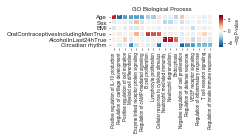

enrichr KEGG_2019_Human GENE_AND_DISTAL_10kb
Some terms were enriched both positively and negatively!!!
Only the stronger direction will be displayed: {'Neuroactive ligand-receptor interaction'}
Some terms were enriched both positively and negatively!!!
Only the stronger direction will be displayed: {'Neuroactive ligand-receptor interaction'}


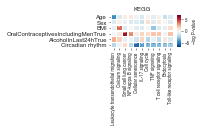

enrichr GO_Biological_Process_2018 TSS_PROXIMAL
Some terms were enriched both positively and negatively!!!
Only the stronger direction will be displayed: {'regulation of immune response (GO:0050776)', 'neutrophil migration (GO:1990266)', 'inflammatory response (GO:0006954)', 'T cell activation involved in immune response (GO:0002286)', 'macrophage activation (GO:0042116)', 'granulocyte chemotaxis (GO:0071621)', 'defense response to bacterium (GO:0042742)', 'chemokine-mediated signaling pathway (GO:0070098)', 'neutrophil mediated immunity (GO:0002446)', 'cellular response to cytokine stimulus (GO:0071345)', 'neutrophil activation involved in immune response (GO:0002283)', 'antibacterial humoral response (GO:0019731)', 'neutrophil chemotaxis (GO:0030593)', 'neutrophil degranulation (GO:0043312)'}
Some terms were enriched both positively and negatively!!!
Only the stronger direction will be displayed: {'regulation of immune response (GO:0050776)', 'neutrophil migration (GO:1990266)', 'inf

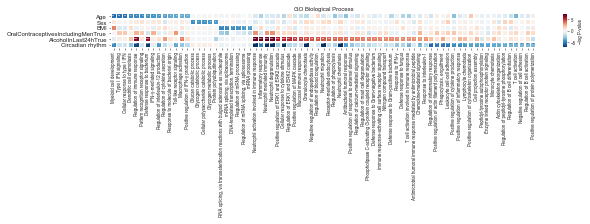

enrichr KEGG_2019_Human TSS_PROXIMAL
Some terms were enriched both positively and negatively!!!
Only the stronger direction will be displayed: {'Tuberculosis', 'Hematopoietic cell lineage', 'Cytokine-cytokine receptor interaction', 'Staphylococcus aureus infection', 'Herpes simplex virus 1 infection'}
Some terms were enriched both positively and negatively!!!
Only the stronger direction will be displayed: {'Tuberculosis', 'Hematopoietic cell lineage', 'Cytokine-cytokine receptor interaction', 'Staphylococcus aureus infection', 'Herpes simplex virus 1 infection'}


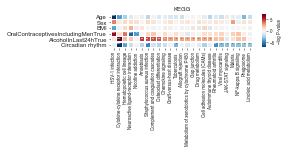

lola HOCOMOCO_v11 None
Some terms were enriched both positively and negatively!!!
Only the stronger direction will be displayed: {'NRF1', 'MBD2', 'ZBT14', 'ARNT', 'E2F2', 'TF7L1', 'MECP2', 'FOSL1', 'SRY', 'CEBPB', 'AHR', 'FOSL2', 'TF7L2', 'FOXC1', 'HINFP', 'NKX61', 'NF2L2', 'JUNB', 'ZKSC1', 'MEF2C', 'KAISO', 'CEBPA', 'E2F5', 'FOXQ1'}
Some terms were enriched both positively and negatively!!!
Only the stronger direction will be displayed: {'NRF1', 'MBD2', 'ZBT14', 'ARNT', 'E2F2', 'TF7L1', 'MECP2', 'FOSL1', 'SRY', 'CEBPB', 'AHR', 'FOSL2', 'TF7L2', 'FOXC1', 'HINFP', 'NKX61', 'NF2L2', 'JUNB', 'ZKSC1', 'MEF2C', 'KAISO', 'CEBPA', 'E2F5', 'FOXQ1'}


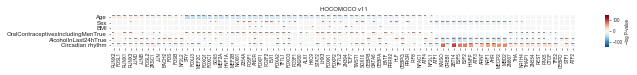

lola Roadmap_Epigenomics_r9 None
Some terms were enriched both positively and negatively!!!
Only the stronger direction will be displayed: {'H3K27ac', 'H3K4me3', 'H3K4me1', 'H3K9ac', 'H3K36me3', 'H3K27me3', 'H3K9me3'}
Some terms were enriched both positively and negatively!!!
Only the stronger direction will be displayed: {'H3K27ac', 'H3K4me3', 'H3K4me1', 'H3K9ac', 'H3K36me3', 'H3K27me3', 'H3K9me3'}


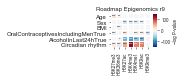

Odds ratio  \
Library                    Gene set                                           Host factor            Association               
GO_Biological_Process_2018 modulation by virus of host morphology or physi... Sample-collection time Negative       7.062509   
KEGG_2019_Human            Small cell lung cancer                             Oral contraceptives    Positive       3.238917   
                           Cellular senescence                                Sample-collection time Negative       2.515013   
                           Epstein-Barr virus infection                       Sample-collection time Negative       2.408534   
                           Viral carcinogenesis                               Sample-collection time Negative       2.336261   

                                                                                                                       P-value  \
Library                    Gene set                                           Host factor            Association                 
GO_Biological_Process_2018 modulation by virus of host morphology or physi... Sample-collection time Negative     6.993741e-08   
KEGG_2019_Human            Small cell lung cancer                             Oral contraceptives    Positive     1.189506e-06   
                           Cellular senescence                                Sample-collection time Negative     2.813418e-06   
                           Epstein-Barr virus infection                       Sample-collection time Negative     5.078652e-06   
                           Viral carcinogenesis                               Sample-collection time Negative     9.436565e-06   

                                                                                                                  Adjusted P-value  \
Library                    Gene set                                           Host factor            Association                     
GO_Biological_Process_2018 modulation by virus of host morphology or physi... Sample-collection time Negative             0.000154   
KEGG_2019_Human            Small cell lung cancer                             Oral contraceptives    Positive             0.000319   
                           Cellular senescence                                Sample-collection time Negative             0.000650   
                           Epstein-Barr virus infection                       Sample-collection time Negative             0.000650   
                           Viral carcinogenesis                               Sample-collection time Negative             0.000805   

                                                                                                                 Overlap  
Library                    Gene set                                           Host factor            Association          
GO_Biological_Process_2018 modulation by virus of host morphology or physi... Sample-collection time Negative      14/96  
KEGG_2019_Human            Small cell lung cancer                             Oral contraceptives    Positive     25/346  
                           Cellular senescence                                Sample-collection time Negative     35/616  
                           Epstein-Barr virus infection                       Sample-collection time Negative     36/660  
                           Viral carcinogenesis                               Sample-collection time Negative     36/679

Odds ratio  \
Library                    Gene set                                           Host factor Association               
KEGG_2019_Human            Herpes simplex virus 1 infection                   Age         Negative       2.710407   
GO_Biological_Process_2018 neutrophil activation involved in immune respon... Alcohol     Positive       2.523502   
KEGG_2019_Human            Cytokine-cytokine receptor interaction             Alcohol     Positive       3.437132   
GO_Biological_Process_2018 inflammatory response (GO:0006954)                 Alcohol     Positive       3.498495   
                           neutrophil mediated immunity (GO:0002446)          Alcohol     Positive       2.369607   

                                                                                                            P-value  \
Library                    Gene set                                           Host factor Association                 
KEGG_2019_Human            Herpes simplex virus 1 infection                   Age         Negative     1.257560e-11   
GO_Biological_Process_2018 neutrophil activation involved in immune respon... Alcohol     Positive     1.940020e-10   
KEGG_2019_Human            Cytokine-cytokine receptor interaction             Alcohol     Positive     7.915458e-09   
GO_Biological_Process_2018 inflammatory response (GO:0006954)                 Alcohol     Positive     2.097851e-09   
                           neutrophil mediated immunity (GO:0002446)          Alcohol     Positive     4.067779e-09   

                                                                                                       Adjusted P-value  \
Library                    Gene set                                           Host factor Association                     
KEGG_2019_Human            Herpes simplex virus 1 infection                   Age         Negative         3.269655e-09   
GO_Biological_Process_2018 neutrophil activation involved in immune respon... Alcohol     Positive         4.277744e-07   
KEGG_2019_Human            Cytokine-cytokine receptor interaction             Alcohol     Positive         2.153005e-06   
GO_Biological_Process_2018 inflammatory response (GO:0006954)                 Alcohol     Positive         2.312881e-06   
                           neutrophil mediated immunity (GO:0002446)          Alcohol     Positive         2.716366e-06   

                                                                                                      Overlap  
Library                    Gene set                                           Host factor Association          
KEGG_2019_Human            Herpes simplex virus 1 infection                   Age         Negative     72/406  
GO_Biological_Process_2018 neutrophil activation involved in immune respon... Alcohol     Positive     72/430  
KEGG_2019_Human            Cytokine-cytokine receptor interaction             Alcohol     Positive     36/165  
GO_Biological_Process_2018 inflammatory response (GO:0006954)                 Alcohol     Positive     38/172  
                           neutrophil mediated immunity (GO:0002446)          Alcohol     Positive     69/433

Odds ratio  \
Library                Region set Host factor            Association               
Roadmap_Epigenomics_r9 H3K4me3    Sample-collection time Positive       5.268530   
HOCOMOCO_v11           ZBT14      Sample-collection time Positive       4.318813   
Roadmap_Epigenomics_r9 H3K4me3    Alcohol                Negative       3.603744   
HOCOMOCO_v11           KAISO      Sample-collection time Positive       3.830727   
                       E2F5       Sample-collection time Positive       3.477984   

                                                                            P-value  \
Library                Region set Host factor            Association                  
Roadmap_Epigenomics_r9 H3K4me3    Sample-collection time Positive     1.995098e-135   
HOCOMOCO_v11           ZBT14      Sample-collection time Positive     8.556418e-105   
Roadmap_Epigenomics_r9 H3K4me3    Alcohol                Negative      2.357766e-86   
HOCOMOCO_v11           KAISO      Sample-collection time Positive      1.050328e-86   
                       E2F5       Sample-collection time Positive      1.638762e-80   

                                                                      Adjusted P-value  \
Library                Region set Host factor            Association                     
Roadmap_Epigenomics_r9 H3K4me3    Sample-collection time Positive        1.396568e-134   
HOCOMOCO_v11           ZBT14      Sample-collection time Positive        3.431124e-102   
Roadmap_Epigenomics_r9 H3K4me3    Alcohol                Negative         1.650436e-85   
HOCOMOCO_v11           KAISO      Sample-collection time Positive         2.105909e-84   
                       E2F5       Sample-collection time Positive         2.190479e-78   

                                                                        Overlap  
Library                Region set Host factor            Association             
Roadmap_Epigenomics_r9 H3K4me3    Sample-collection time Positive     747/23396  
HOCOMOCO_v11           ZBT14      Sample-collection time Positive     745/26192  
Roadmap_Epigenomics_r9 H3K4me3    Alcohol                Negative     670/23396  
HOCOMOCO_v11           KAISO      Sample-collection time Positive     755/28870  
                       E2F5       Sample-collection time Positive     691/25371

In [10]:
selected_subset = [
    'VEGF receptor signaling',
    'Positive regulation of IL-10 production',
#     'Regulation of IL-10 production',
    'Positive regulation of cell migration',
    'Myeloid cell differentiation',
    'Regulation of cAMP-mediated signaling',
    'Calcium signaling',
    'B cell proliferation',
    'NF-kappa B signaling',
    'Lymphocyte proliferation',
    'Cellular response to cytokine stimulus',
    'Neutrophil mediated immunity',
    'Neutrophil degranulation',
    'Cellular response to cytokine stimulus',
    'IL-17 signaling',
    'Myeloid cell differentiation',
    'Regulation of defense response',
    'Cell cycle',
    'TNF signaling',
    'T cell receptor signaling',
    'Toll-like receptor signaling',
    'Negative regulation of homeostatic',
    'Regulation of inflammatory response',
    'Regulation of innate immune response',
    'Regulation of cartilage development',
    'Negative regulation of cell proliferation',
    'Leukocyte transendothelial migration',
    'Cellular senescence',
    'Enzyme linked receptor protein signaling',
#     'Neuroactive ligand-receptor interaction',
    'Small cell lung cancer',
#     'Toxoplasmosis',
    'Endocytosis',
]

suppl_dict = defaultdict(lambda: defaultdict(lambda: {}))
for method, library, region_filter, vmax, vmin, pthw_fdr_or_top_n, subset in [
    ('enrichr', misc.GO_BIO_PROCESS, misc.GENE_AND_DISTAL_10kb, ENR_VMAX, ENR_VMIN, 0.05, selected_subset),
    ('enrichr', misc.KEGG, misc.GENE_AND_DISTAL_10kb, ENR_VMAX, ENR_VMIN, 0.05, selected_subset),
    ('enrichr', misc.GO_BIO_PROCESS, misc.TSS_PROXIMAL, ENR_VMAX, ENR_VMIN, 0.05, None),
    ('enrichr', misc.KEGG, misc.TSS_PROXIMAL, ENR_VMAX, ENR_VMIN, 0.05, None),
    ('lola', HOCOMOCO, None, LOLA_VMAX, LOLA_VMIN, 10, None),
    ('lola', EPI_ROADMAP, None, LOLA_VMAX, LOLA_VMIN, 10, None),
]:
    print(method, library, region_filter)

    tcr_signals = None
    kws = dict(celltype=CELLTYPE, model=MODEL, contrasts=HOST_FACTORS, method=method, library=library + ('_min15_max500' if method == 'enrichr' else ''),
               top_n=TOP_N, region_filter=region_filter, pthw_fdr_or_top_n=pthw_fdr_or_top_n, pval_asterisks=PVAL_ASTERISKS,
               transpose=TRANSPOSE_ENR_TABLE, fig_width=ENR_FIG_WIDTH, cell_height=ENR_CELL_HEIGHT,
               fmt='.0e', annot_size=ASTERISK_FONT, save_fig=False, show_fig=False, fig_format='svg')

    _, results, _ = misc.enr_heatmap(**kws, rename_pthw=False, heatmap_kws=dict(vmax=vmax, vmin=vmin, lw=0.5),
                                     cbar_kws=dict(shrink=0.2, aspect=8, orientation='vertical'), annot_kws={})
    plt.close()

    idx = None
    pvals = results['pval'] if TRANSPOSE_ENR_TABLE else results['pval'].T
    padjs = results['padj'] if TRANSPOSE_ENR_TABLE else results['padj'].T
    pvals.columns.union(padjs.columns)
    for factor in pvals.index:
        this_factor_idx = pvals.where(padjs <= np.min(FDR)).loc[factor]
        this_factor_idx.loc[this_factor_idx > 0] *= 1000
        this_factor_idx = this_factor_idx.abs().sort_values(ascending=False)
        this_factor_idx = this_factor_idx.loc[~this_factor_idx.isnull()].index
        if idx is None:
            idx = this_factor_idx
        elif len(this_factor_idx) != 0:
            idx = pd.Index(np.concatenate([idx, [i for i in this_factor_idx if i not in idx]]))

    if subset is not None:
        idx = idx[np.isin(rename_pathways(idx), subset)]
        # do not repeat the same pathway for both libraries
        TCR = 'T cell receptor signaling pathway'
        if TCR in idx and library == misc.GO_BIO_PROCESS:
            tcr_signals = results['padj'].where(results['padj'] <= np.min(FDR)).T.loc[TCR].isnull()
        elif TCR in idx and tcr_signals is not None and library == misc.KEGG:
            if results['padj'].where(results['padj'] <= np.min(FDR)).T.loc[TCR].isnull().equals(tcr_signals):
                idx = idx[idx != TCR]

    ax, results, enr_df = misc.enr_heatmap(force_index=idx, **kws, rename_pthw=True, heatmap_kws=dict(vmax=vmax, vmin=vmin, lw=0.5),
                                           cbar_kws=dict(shrink=0.2, aspect=8, orientation='vertical'), annot_kws={})

    ax.set_yticklabels([rename_factors(t.get_text().replace('SAMPLE.', '').replace('DONOR.', '').replace('SEXM', 'SEX')) for t in ax.get_yticklabels()])
    ax.tick_params(axis='x', labelsize=SMALL_FONT)
    ax.collections[0].colorbar.ax.set_ylabel('{}log P-value'.format(utils.MINUS), fontsize=SMALL_FONT)
    ax.collections[0].colorbar.ax.tick_params(axis='both', which='both', labelsize=SMALL_FONT)
    ax.set_title(' '.join(library.split('_201')[0].split('_')), pad=3)
    if SAVE_FIG:
        utils.savefig(os.path.join(fig_dir, 'enr_{}_{}_{}_fdr{}{}.svg'.format(
            MODEL, library, region_filter, pthw_fdr_or_top_n, '_full' if not subset else '')), dpi=DPI)
    plt.show()

    if SAVE_TABLES:
        suppl_dict[method][region_filter][library] = enr_df.copy()

for method, region_filter, table_name, fig_n in [
    ('enrichr', misc.GENE_AND_DISTAL_10kb, ENRICH_V1, '2H'),
    ('enrichr', misc.TSS_PROXIMAL, ENRICH_V1_PROMOTERS, None),
    ('lola', None, ENRICH_V1_LOLA, None)
]:
    if SAVE_TABLES:
        suppl_df = misc.suppl_table_enrich_d0_host_factors(suppl_dict[method][region_filter], HOST_FACTORS, method=method, limit_FDR=None,
                                                           promoters=region_filter == misc.TSS_PROXIMAL,
                                                           suppl_tables=suppl_tables, table_name=table_name, fig_n=fig_n)
        display(suppl_df.head())

In [11]:
if SAVE_TABLES:
    infos, tables = misc.close_tables_and_save(suppl_tables)
    for table, df in zip(tables, infos):
        print(table)
        display(df)

S03_ATACseq_d0


,Contents
Sheet name,
donorVar,Fraction of variance explained (FVE) by donor ...
d0_age,Association of chromatin accessibility with ag...
d0_sex,Association of chromatin accessibility with se...
d0_BMI,Association of chromatin accessibility with BM...
d0_oralContraceptives,Association of chromatin accessibility with or...
d0_alcohol,Association of chromatin accessibility with al...
d0_sampleCollectionTime,Association of chromatin accessibility with sa...


S04_ATACseq_d0_geneSets


,Contents
Sheet name,
donorVar,Chromatin accessibility gene set enrichment of...
d0_age,Chromatin accessibility gene set enrichment of...
d0_sex,Chromatin accessibility gene set enrichment of...
d0_BMI,Chromatin accessibility gene set enrichment of...
d0_oralContraceptives,Chromatin accessibility gene set enrichment of...
d0_alcohol,Chromatin accessibility gene set enrichment of...
d0_sampleCollectionTime,Chromatin accessibility gene set enrichment of...


Ext_S03.1_ATACseq_d0_hostFactors


,Contents
Sheet name,
donorVar,Fraction of variance explained (FVE) by donor ...
d0_age,Association of chromatin accessibility with ag...
d0_sex,Association of chromatin accessibility with se...
d0_BMI,Association of chromatin accessibility with BM...
d0_oralContraceptives,Association of chromatin accessibility with or...
d0_alcohol,Association of chromatin accessibility with al...
d0_sampleCollectionTime,Association of chromatin accessibility with sa...


Ext_S04.1_ATACseq_d0_geneSets_promoters


,Contents
Sheet name,
donorVar,Chromatin accessibility gene set enrichment of...
d0_age,Chromatin accessibility gene set enrichment of...
d0_sex,Chromatin accessibility gene set enrichment of...
d0_BMI,Chromatin accessibility gene set enrichment of...
d0_oralContraceptives,Chromatin accessibility gene set enrichment of...
d0_alcohol,Chromatin accessibility gene set enrichment of...
d0_sampleCollectionTime,Chromatin accessibility gene set enrichment of...


Ext_S04.2_ATACseq_d0_regionSets


,Contents
Sheet name,
donorVar,Chromatin accessibility region set enrichment ...
d0_age,Chromatin accessibility region set enrichment ...
d0_sex,Chromatin accessibility region set enrichment ...
d0_BMI,Chromatin accessibility region set enrichment ...
d0_oralContraceptives,Chromatin accessibility region set enrichment ...
d0_alcohol,Chromatin accessibility region set enrichment ...
d0_sampleCollectionTime,Chromatin accessibility region set enrichment ...


In [12]:
misc.fix_font_for_suppl_tables(suppl_tables)